In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *


import matplotlib.pyplot as plt

In [2]:
feos_pcsaft.__file__

'/usr/ITT/bursik/promotion/code/feos/feos-dft/venv/lib/python3.8/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

# Local DFT Implementation

In [3]:
components = ['hexane', 'pentane']
composition = np.array([0.3, 0.7]) *MOL
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [4]:
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')
func = PcSaftFunctional(params)
func_hs = (params)

In [5]:
composition 

[0.3, 0.7] mol

In [6]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)

In [7]:
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

In [8]:
interface.local_weighted_densities

[array([[1.37911241e-02, 1.37911240e-02, 1.37911248e-02, ...,
         3.65092755e-05, 3.65100479e-05, 3.65099771e-05],
        [2.57737134e-02, 2.57737132e-02, 2.57737147e-02, ...,
         6.81309359e-05, 6.81323795e-05, 6.81322470e-05],
        [6.05298172e-01, 6.05298169e-01, 6.05298202e-01, ...,
         1.59771017e-03, 1.59774407e-03, 1.59774096e-03],
        [3.77082007e-01, 3.77082005e-01, 3.77082018e-01, ...,
         9.93854067e-04, 9.93866589e-04, 9.93865279e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[1.47763668e-03, 1.47763667e-03, 1.47763667e-03, ...,
         1.53534449e-06, 1.53534300e-06, 1.53534156e-06],
        [3.44781891e-03, 3.44781891e-03, 3.44781890e-03, ...,
         1.18290599e-05, 1.18290565e-05, 1.18290531e-05],
        [1.47763631e-03, 1.47763628e-0

In [19]:
print("len(interface.density) =", len(interface.density))
print("interface.density.shape =", interface.density.shape)
print("len(interface.weighted_densities) =", len(interface.weighted_densities))
print("interface.weighted_densities[0].shape =", interface.weighted_densities[0].shape)
print("interface.weighted_densities[1].shape =", interface.weighted_densities[1].shape)
print("interface.weighted_densities[2].shape =", interface.weighted_densities[2].shape)
print("len(interface.functional_derivative) =", len(interface.functional_derivative))
print("interface.functional_derivative.shape =", interface.functional_derivative.shape)
print("interface.functional_derivative[0].shape =", interface.functional_derivative[0].shape)
print("interface.functional_derivative[1].shape =", interface.functional_derivative[1].shape)


len(interface.density) = 2048
interface.density.shape = [2, 1024]
len(interface.weighted_densities) = 3
interface.weighted_densities[0].shape = (6, 1024)
interface.weighted_densities[1].shape = (6, 1024)
interface.weighted_densities[2].shape = (2, 1024)
len(interface.functional_derivative) = 2
interface.functional_derivative.shape = (2, 1024)
interface.functional_derivative[0].shape = (1024,)
interface.functional_derivative[1].shape = (1024,)


In [10]:
interface.local_weighted_densities[2]

array([[1.47763625e-03, 1.47763622e-03, 1.47763661e-03, ...,
        1.53540296e-06, 1.53579446e-06, 1.53576428e-06],
       [3.44781794e-03, 3.44781787e-03, 3.44781877e-03, ...,
        1.18291941e-05, 1.18300920e-05, 1.18300228e-05]])

In [11]:
len(interface.local_weighted_densities)

3

In [12]:
print("len(interface.density) =", len(interface.density))
print("interface.density.shape =", interface.density.shape)
print("len(interface.local_weighted_densities) =", len(interface.local_weighted_densities))
print("interface.local_weighted_densities[0].shape =", interface.local_weighted_densities[0].shape)
print("interface.local_weighted_densities[1].shape =", interface.local_weighted_densities[1].shape)
print("interface.local_weighted_densities[2].shape =", interface.local_weighted_densities[2].shape)
print("len(interface.functional_derivative) =", len(interface.functional_derivative))

len(interface.density) = 2048
interface.density.shape = [2, 1024]
len(interface.local_weighted_densities) = 3
interface.local_weighted_densities[0].shape = (6, 1024)
interface.local_weighted_densities[1].shape = (6, 1024)
interface.local_weighted_densities[2].shape = (2, 1024)
len(interface.functional_derivative) = 2


In [13]:
print("interface.local_weighted_densities[0].shape =", interface.local_weighted_densities[0].shape)

interface.local_weighted_densities[0].shape = (6, 1024)


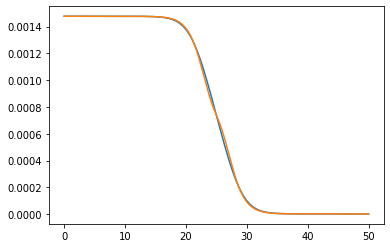

In [14]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.weighted_densities)[1][2,:])
plt.plot(interface.z / ANGSTROM, (interface.local_weighted_densities)[1][2,:])


(6, 1024)
plotted
plotted
plotted
plotted
plotted
plotted
(6, 1024)
plotted
plotted
plotted
plotted
plotted
plotted
(2, 1024)
plotted
plotted


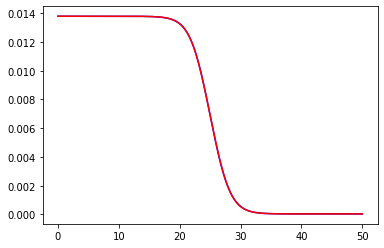

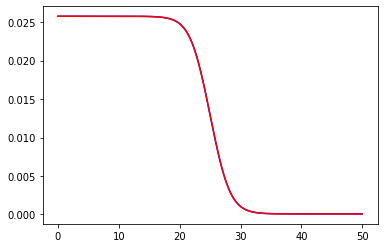

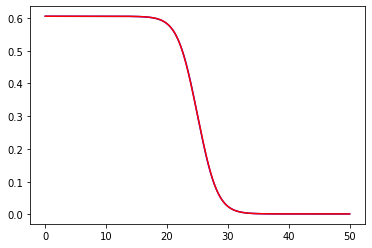

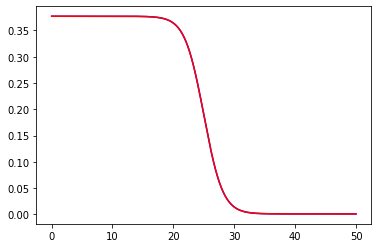

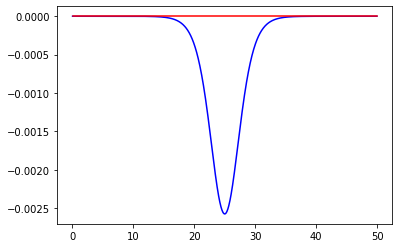

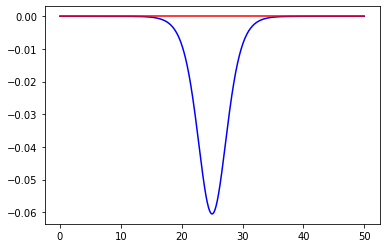

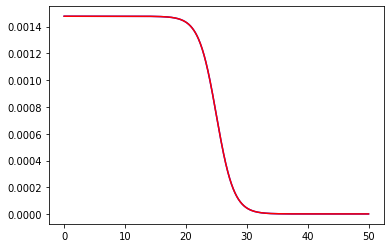

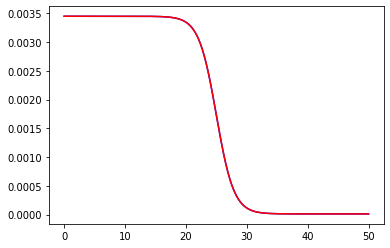

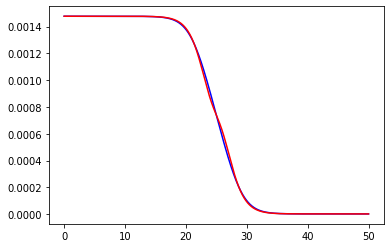

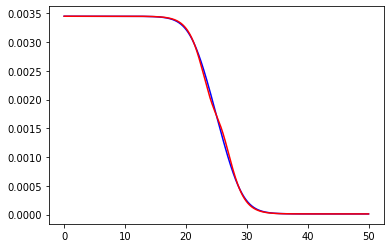

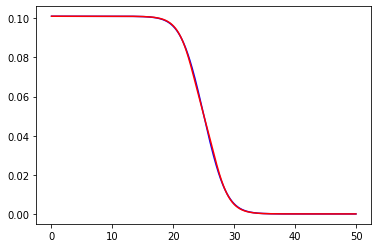

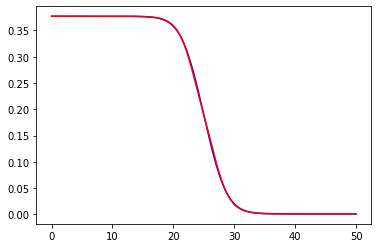

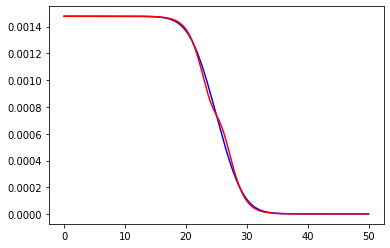

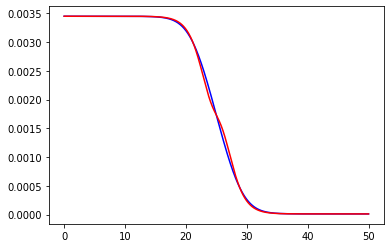

In [15]:
# plot initial density profile
for wds, lwds in zip(interface.weighted_densities, interface.local_weighted_densities):
    print(wds.shape)
    for wd, lwd in zip(wds, lwds):
        plt.figure()
        plt.plot(interface.z / ANGSTROM, wd, 'b')
        plt.plot(interface.z / ANGSTROM, lwd, 'r')
        print('plotted')
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [11]:
wd = interface.weighted_densities
plt.plot(interface.z / ANGSTROM, (wd / MOL * METER**3)[0,:])
print(len(wd))
print(wd[1].shape)

TypeError: not implemented!

## DFT Example

In [10]:
## Planar Interface 

In [11]:
# system specification
components = ['hexane', 'octane'] # ['hexane'] # 
x = 0.3
composition = np.array([x, 1-x])
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [12]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [13]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [14]:
# calculate phase equilibrium
#vle = PhaseEquilibrium.pure_t(func, temperature)
vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition)
vle


||temperature|density|molefracs|
|-|-|-|-|
|phase 1|298.15 K|2.964357865432749  mol/m³|[0.81911, 0.18089]|
|phase 2|298.15 K|6.446506873296946 kmol/m³|[0.30000, 0.70000]|


In [15]:
# calculate critical point (needed for initializiation of tanh profile)
#t_crit = State.critical_point_pure(func)[0].temperature
t_crit = State.critical_point(func, 1 * MOL *composition).temperature
t_crit

568.0769398960161 K

In [16]:
# intialize solver and interface density profile
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

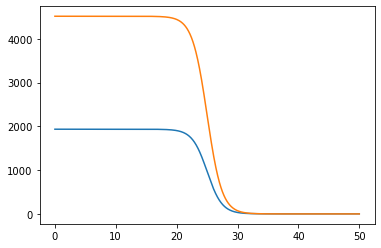

In [17]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [18]:
# solve DFT
interface.solve(solver)

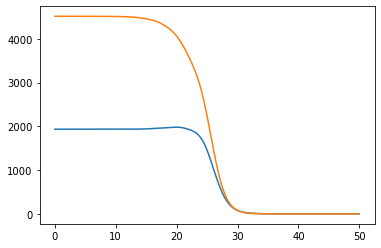

In [19]:
# plot final density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [20]:
# print surface tension
interface.surface_tension

20.13926529391086 mN/m

In [21]:
interface.equimolar_radius

2.4999964243533226 nm

# Adsorption at a wall in 1D

In [26]:
# system specification
components =  ['butane', 'pentane']
x = 0.5
composition = np.array([x, 1-x])
temperature = 250.15* KELVIN
pressure = 1 * BAR

In [27]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [28]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [30]:
# Create State 
state = State(func, temperature, pressure=pressure, molefracs=composition)

In [31]:
# create potential 
#potential  = ExternalPotential.LJ93(3.0, 250.0, 0.08)
potential  = ExternalPotential.HardWall(3.1)


In [44]:
np.array([[5,5]*ANGSTROM,[10,10]*ANGSTROM])

TypeError: not implemented!

In [ ]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore3D(func,[50*ANGSTROM, 50*ANGSTROM, 50*ANGSTROM], [128,128,128] ,None, np.array([3,3]),np.array([150,150])     ).initialize(state)

In [40]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore3D(func,[50*ANGSTROM, 50*ANGSTROM, 50*ANGSTROM], [128,128,128] ,None, np.array([3,3]),np.array([150,150])     ).initialize(state)

TypeError: argument 'coordinates': 'NoneType' object cannot be converted to 'SIArray2'

In [33]:
wall_profile.weighted_densities

[/home/bursik/promotion/code/feos/feos-dft/src/profile.rs:351] densities.raw_dim()

[array([[ 1.48663434e-02,  1.48663434e-02,  1.48663434e-02, ...,
         -6.54120855e-14,  3.92498534e-14, -1.30806824e-14],
        [ 2.76040842e-02,  2.76040842e-02,  2.76040842e-02, ...,
         -1.21347377e-13,  7.28063443e-14, -2.42722509e-14],
        [ 6.44150434e-01,  6.44150434e-01,  6.44150434e-01, ...,
         -2.82901480e-12,  1.69741998e-12, -5.65825165e-13],
        [ 3.98753959e-01,  3.98753959e-01,  3.98753959e-01, ...,
         -6.46704912e-15,  7.63278329e-15,  4.99600361e-16],
        [ 8.32774362e-12, -8.32775969e-12,  8.32779151e-12, ...,
          2.72896432e-11, -2.72891901e-11,  2.72889636e-11],
        [ 1.94534508e-10, -1.94534884e-10,  1.94535626e-10, ...,
          6.37308274e-10, -6.37297701e-10,  6.37292418e-10]]),
 array([[ 2.96076596e-03,  2.96076596e-03,  2.96076596e-03, ...,
          5.71057690e-25,  5.71057690e-25,  5.71057690e-25],
        [ 2.96076596e-03,  2.96076596e-03,  2.96076596e-03, ...,
          5.71057690e-25,  5.71057690e-25,  5.71057

 = [2, 2048]
[/home/bursik/promotion/code/feos/feos-dft/src/profile.rs:352] dx = 0.015891535156249997


In [28]:
# set solver
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-6, max_iter=1000).anderson_mixing(tol=1.0e-8, max_iter=500, mmax=10)

In [ ]:
# solve DFT for wall 
wall_profile.solve(solver)

In [ ]:
# plot resulting density profile
plt.plot(wall_profile.z/ANGSTROM, (wall_profile.density/MOL*METER**3)[0,:])

In [ ]:
wall_profile.density/MOL*METER**3